In [1]:
from distmesh import *
from FEM_TPT import *
import numpy as np
import math
import matplotlib.pyplot as plt
import csv 

In [2]:
# finds the committor, the reactive current, and the reaction rate for the Maier-Stein SDE
# using the finite element method and the distmesh triangulation

# the committor equation 

# b(x,y) \cdot \nabla q(x,y) + (epsilon/2) \Delta q(x,y) = 0, (x,y) \in (A\cup B)^c
# q(\partial A) = 0, q(\partial B) = 1
# dq/dn = 0, (x,y) \in outer boundaty defined by {x : fpot(x) = Vbdry}

# the homogeneous Neumann boundary condition dq/dn = 0 means that 
# the trajectory reflects from the outer boundary whenever it reaches it

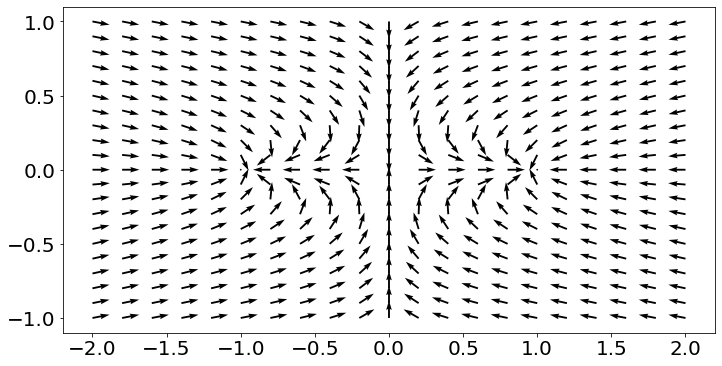

In [3]:
# parameters for Mueller's potential
xa=-1
ya=0 
xb=1 
yb=0

# problem setup: choose sets A and B and the outer boundary
# set A is the circle with center at (xa,ya) and radius ra
# set B is the circle with center at (xb,yb) and radius rb
ra = 0.3 # radius of set A
rb = 0.3 # radius of set B
epsilon = 0.1 # beta = 1/(k_B T), T = temperature, k_B = Boltzmann's constant
Vbdry = 100 # level set of the outer boundary {x : fpot(x) = Vbdry}

# if generate_mesh = True, mesh is generated and saves as csv files
# if generate_mesh = False, mesh is downloaded from those csv files
generate_mesh = True

# h0 is the desired scalind parameter for the mesh
h0 = 0.03

# beta is a parameter for Maier-Stein drift
MSpar = 10.0
def MaierStein(x,y):
    # gamma = torch.tensor([9])
    # k = torch.tensor([5])
    drift1 = x-x**3-MSpar*x*y**2
    drift2 = -(1.0+x**2)*y
    return drift1,drift2

def MaierStein_div(x,y):
    return -4*x**2 - MSpar*y**2

def MSpot(x):
    return 0.25*x[:,0]**4 - 0.5*x[:,0]**2 + 0.25*(MSpar+1.0)*(x[:,0]*x[:,1])**2 + 0.5*x[:,1]**2

def MSdivfree(x,y):
    f1 = -0.5*(MSpar-1.0)*x*y**2
    f2 = 0.5*(MSpar-1.0)*y*x**2
    return f1,f2
    
# define face potential on a meshgrid
nx,ny= (21,21)
nxy = nx*ny
xmin = -2.0
xmax = 2.0
ymin = -1
ymax = 1
x1 = np.linspace(xmin,xmax,nx)
y1 = np.linspace(ymin,ymax,ny)
x_grid, y_grid = np.meshgrid(x1,y1)
drift1,drift2 = MaierStein(x_grid,y_grid)
dnorm = np.sqrt(drift1**2+drift2**2+1e-12)
# graphics
plt.figure(figsize=(16, 6))
plt.rcParams.update({'font.size': 20})
plt.quiver(x_grid,y_grid,drift1/dnorm,drift2/dnorm)
axes=plt.gca()
axes.set_aspect(1)


In [4]:
# generate a trajectory
Ntraj = 1000000
h=1e-3 # time step
sqh = math.sqrt(h*epsilon)
print(sqh)
px = np.zeros((Ntraj,))
py = np.zeros((Ntraj,))
w = sqh*np.random.normal(0,1,(Ntraj-1,2));
# initial point
px[0] = xa
py[0] = ya
for k in range(Ntraj-1):
    drift1,drift2 = MaierStein(px[k],py[k])
    px[k+1] = px[k] + drift1*h + w[k,0]
    py[k+1] = py[k] + drift2*h + w[k,1]

NA = int(np.round(2*np.pi*ra/h0)) # the number of points on the A-circle
NB = int(np.round(2*np.pi*rb/h0)) # the number of points on the B-circle
         
ptsA = put_pts_on_circle(xa,ya,ra,NA) 
ptsB = put_pts_on_circle(xb,yb,rb,NB)  

0.01


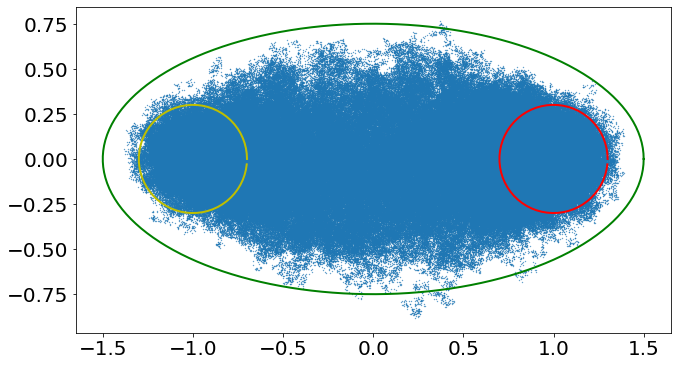

In [5]:
plt.figure(figsize=(16, 6))
plt.scatter(px,py,s=0.1)
plt.plot(ptsA[:,0],ptsA[:,1],linewidth = 2,c = 'y')
plt.plot(ptsB[:,0],ptsB[:,1],linewidth = 2,c = 'r')
axes=plt.gca()
axes.set_aspect(1)
Nt = int(np.round(2*np.pi*1.5/h0))
t = np.linspace(0,2*np.pi,Nt+1)
Rx = 1.5
Ry = 0.75
bdry_x = Rx*np.cos(t)
bdry_y = Ry*np.sin(t)
bdry = np.concatenate((np.reshape(bdry_x[0:Nt],(Nt,1)),np.reshape(bdry_y[0:Nt],(Nt,1))),axis = 1)
plt.plot(bdry_x,bdry_y,linewidth = 2,c = 'g')

(314, 2)
314
count =  200 displacement =  0.011792458685809038
count =  400 displacement =  0.003775180477396242
count =  800 displacement =  0.007176090304105164
count =  1000 displacement =  0.005035580395430916
count =  1400 displacement =  0.0036438946592034535
count =  1600 displacement =  0.006623845957879379
Npts =  4224  Ntri =  8010


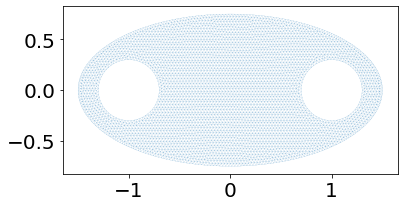

In [6]:
# input data for triangulation
# bbox = [xmin,xmax,ymin,ymax]
print(np.shape(bdry))
print(Nt)
Nfix = NA+NB+Nt
if generate_mesh == True:
    bbox = [xmin,xmax,ymin,ymax]
    pfix = np.zeros((Nfix,2))
    pfix[0:NA,:] = ptsA
    pfix[NA:NA+NB,:] = ptsB
    pfix[NA+NB:Nfix,:] = bdry

    def dfunc(p):
        d0 = dellipse(p,0.0,0.0,Rx,Ry)
        dA = dcircle(p,xa,ya,ra)
        dB = dcircle(p,xb,yb,rb)
        d = ddiff(d0,dunion(dA,dB))
        return d

    pts,tri = distmesh2D(dfunc,huniform,h0,bbox,pfix)
    with open('MaierStein_pts.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(pts)

    with open('MaierStein_tri.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(tri)
else:
    pts = np.loadtxt('MaierStein_pts.csv', delimiter=',', dtype=float)
    tri = np.loadtxt('MaierStein_tri.csv', delimiter=',', dtype=int)

Npts = np.size(pts,axis=0)
Ntri = np.size(tri,axis=0)
print("Npts = ",Npts," Ntri = ",Ntri)    

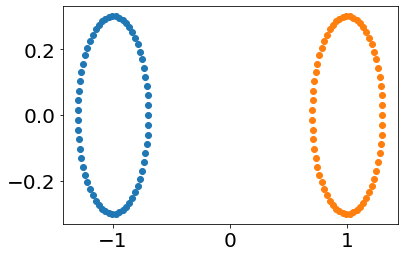

In [7]:
# FEM_committor_solver_irreversible(pts,tri,Aind,Bind,Fpts,drift,divergence,eps05)
NAind,Aind = find_ABbdry_pts(pts,xa,ya,ra,h0) # find mesh points on \partial A
NBind,Bind = find_ABbdry_pts(pts,xb,yb,rb,h0) # find mesh points on \partial B
plt.scatter(pts[Aind,0],pts[Aind,1])
plt.scatter(pts[Bind,0],pts[Bind,1])


In [8]:
q = FEM_committor_solver_irreversible(pts,tri,Aind,Bind,MSpot,MSdivfree,2.0/epsilon)
print(q[Bind])
print(q[Aind])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


0.0 1.0


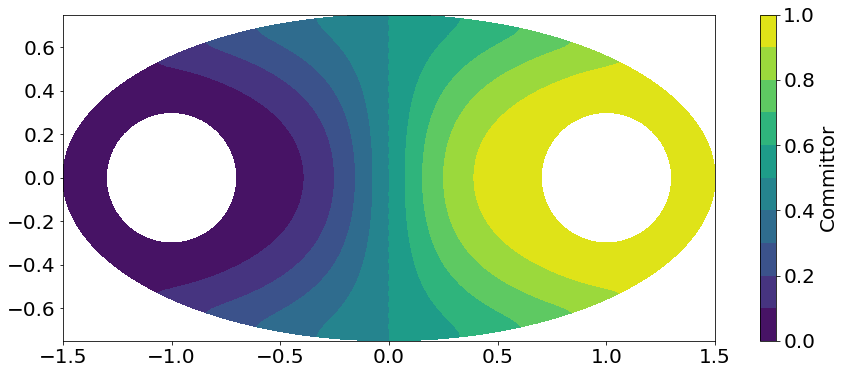

In [9]:
# visualize the committor
qmin = np.amin(q)
qmax = np.amax(q)
print(qmin,qmax)
plt.figure(figsize=(16, 6))
plt.tricontourf(pts[:,0], pts[:,1],tri,q,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]))
#plt.scatter(pts[:,0],pts[:,1],c=q)
plt.colorbar(label="Committor", orientation="vertical")
axes=plt.gca()
axes.set_aspect(1)
plt.rcParams.update({'font.size': 20})
plt.savefig('MaierStein_committor.pdf')

In [10]:
# q = FEM_committor_solver(pts,tri,Aind,Bind,MSpot,2/epsilon)
# # visualize the committor
# qmin = np.amin(q)
# qmax = np.amax(q)
# print(qmin,qmax)
# #plt.tricontourf(pts[:,0], pts[:,1],tri,q,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1]))
# plt.scatter(pts[:,0],pts[:,1],c=q)
# plt.colorbar(label="Committor", orientation="vertical")
# axes=plt.gca()
# axes.set_aspect(1)
# plt.rcParams.update({'font.size': 20})
# plt.savefig('MaierStein_committor.pdf')


In [13]:
print(type(q))
print(q.shape)
print(pts.shape)

<class 'numpy.ndarray'>
(4224,)
(4224, 2)


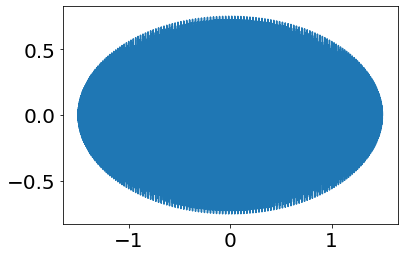

In [14]:
plt.plot(pts[:,0],pts[:,1])

In [19]:
with open('MaierStein_q_FEM.csv', 'w', newline='') as file:
        mywriter = csv.writer(file, delimiter=',')
        mywriter.writerows(q[:,None])